## NECESSARY IMPORTS AND VARIABLES

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image


import os, cv2, time
from albumentations import (Compose, HorizontalFlip, RandomRotate90, MotionBlur)
from keras.backend import clear_session

from sklearn.model_selection import KFold

In [ ]:
batch_size = 16
img_height = 224
img_width = 224
SIZE = 224
num_channels = 3 # RGB
#labels = ['No_Billboard', 'Billboard']
INPUT_SHAPE = (img_height, img_width)
SHAPE = (img_height, img_width, num_channels)

data_dir_path = "/python_programming/FYP_2022/billboard_dataset/output1/"

dataset = []  #Many ways to handle data, you can use pandas.
label = []  #Place holders to define add labels. We will add 0 to all no_billboards  images and 1 to billboards.

## LOADING IN THE DATA

In [ ]:
no_bilboard_images = os.listdir(data_dir_path + 'No_Billboard/')
for i, image_name in enumerate(no_bilboard_images):    #Remember enumerate method adds a counter and returns the enumerate object

    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(data_dir_path + 'No_Billboard/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1
billboard_images = os.listdir(data_dir_path + 'Billboard/')
for i, image_name in enumerate(billboard_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(data_dir_path + 'Billboard/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)

dataset = np.array(dataset)
label = np.array(label)

(3020, 224, 224, 3)
(3020,)
Label for this image is:  1


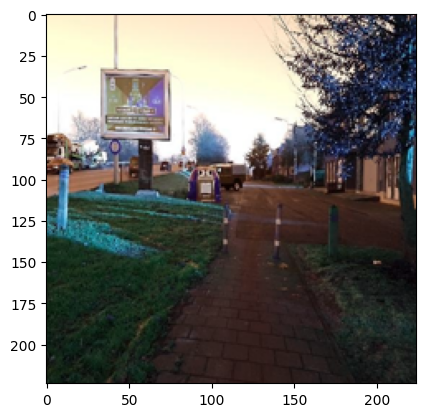

In [ ]:
print(dataset.shape)
print(label.shape)


#Sanity check, view random few mages
import random
import numpy as np
image_number = random.randint(0, len(dataset)-1)
plt.imshow(np.reshape(dataset[image_number], (224, 224, 3)))
print("Label for this image is: ", label[image_number])

In [ ]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

#from keras.utils import normalize
#X_train = normalize(X_train, axis=1)
#X_test = normalize(X_test, axis=1)
X_train = X_train / 255.
X_test = X_test / 255.

#Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0) #labels

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

## TRAINING MODEL

In [ ]:
model_save_name = 'VGG19classifierkfold.pt'
path = f"/python_programming/FYP_2022/Models/{model_save_name}"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    verbose= 1,
    filepath=path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [ ]:
base_VGG_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape= (img_height, img_width, num_channels),
    include_top=False)  # Do not include the ImageNet classifier at the top.
for layer in base_VGG_model.layers[0:5]:
    layer.trainable = False

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 253f8cb515780f3b799900260a226db6 so we will re-download the data.
80142336/80134624 [==============================] - 4s 0us/step


In [ ]:
ADNET_model = tf.keras.models.Sequential(base_VGG_model.layers[:-2])
ADNET_model.add(keras.layers.Conv2D(512, (3,3), activation='relu'))
ADNET_model.add(keras.layers.Flatten())
ADNET_model.add(keras.layers.Dense(1024, activation='relu'))
ADNET_model.add(keras.layers.Dropout(0.5))
ADNET_model.add(keras.layers.Dense(1024, activation='relu'))
ADNET_model.add(keras.layers.Dense(2, activation='softmax'))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

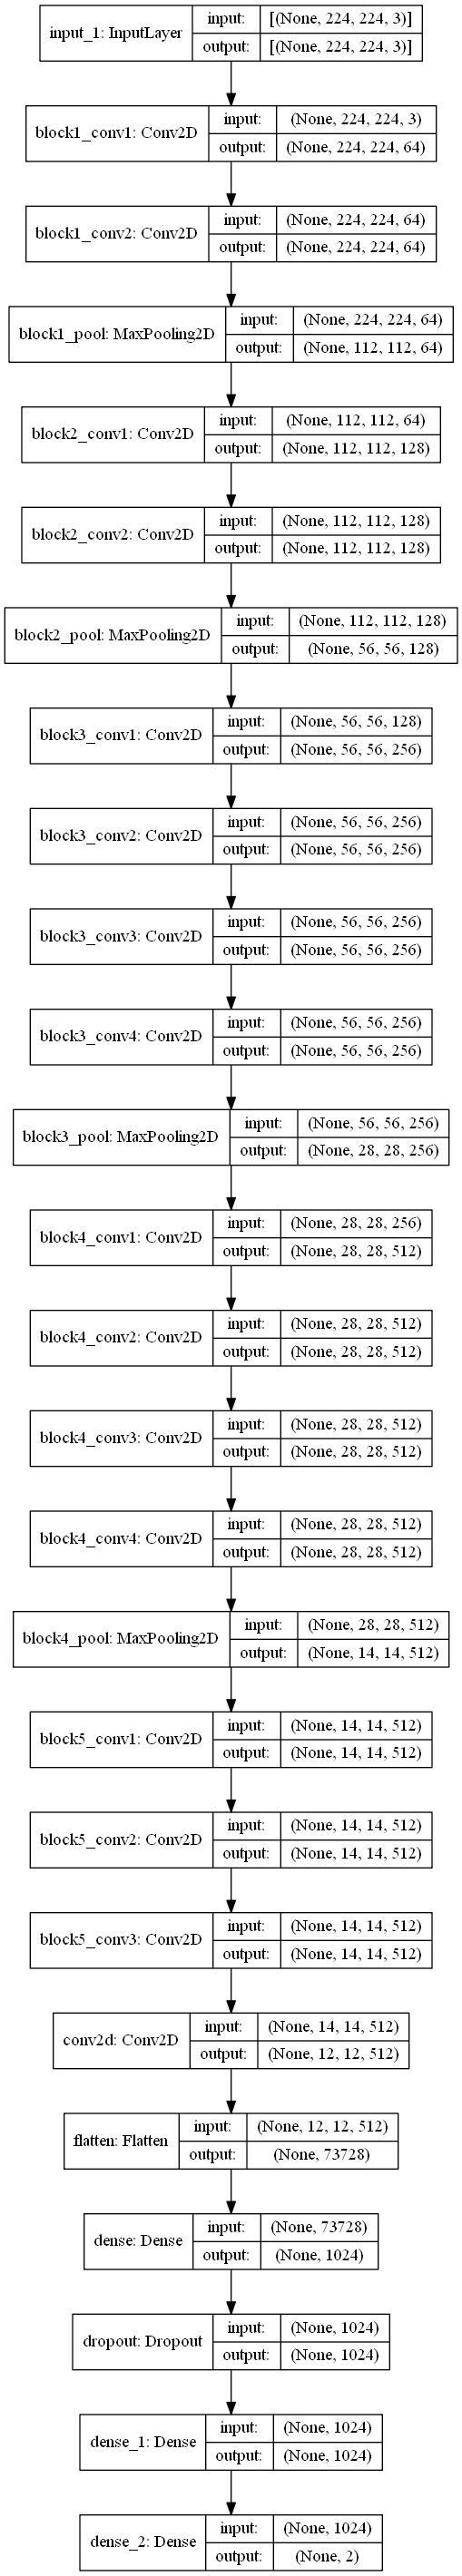

In [ ]:
ADNET_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate= 0.0001),
        metrics=["accuracy"],
    )

print(ADNET_model.summary())
tf.keras.utils.plot_model(ADNET_model, show_shapes=True)#show_shapes=True

In [ ]:
start_time = time.time()

fold_no = 1

num_folds = 10  # Number of splits for k-fold cross-validation
kf = KFold(n_splits=num_folds)


for train, test in kf.split(inputs, targets):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history =ADNET_model.fit(
        X_train, y_train,
        validation_data=(X_test,y_test),
        batch_size=batch_size,
        epochs=50,
        steps_per_epoch=45,
        callbacks=[earlyStopping,model_checkpoint_callback]
    )

    # Generate generalization metrics
    scores = ADNET_model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {ADNET_model.metrics_names[0]} of {scores[0]}; {ADNET_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
45/45 [==============================] - 47s 588ms/step - loss: 0.6916 - accuracy: 0.5653 - val_loss: 0.6262 - val_accuracy: 0.6175

Epoch 00001: val_accuracy improved from -inf to 0.61755, saving model to /python_programming/FYP_2022/Models\VGG19classifierkfold.pt
Epoch 2/50
45/45 [==============================] - 13s 290ms/step - loss: 0.6080 - accuracy: 0.6597 - val_loss: 0.5754 - val_accuracy: 0.6391

Epoch 00002: val_accuracy improved from 0.61755 to 0.63907, saving model to /python_programming/FYP_2022/Models\VGG19classifierkfold.pt
Epoch 3/50
45/45 [==============================] - 13s 291ms/step - loss: 0.5542 - accuracy: 0.7208 - val_loss: 0.5127 - val_accuracy: 0.7930

Epoch 00003: val_accuracy improved from 0.63907 to 0.79305, saving model to /python_programming/FYP_2022/Models\VGG19classifierkfold.pt
Epoch 4/50
45/45 [==============================] - 13s 292ms/step

In [ ]:
elapsed_time = time.time() - start_time
print(f"Elapsed time to complete training: {elapsed_time:.3f} seconds")

elapsed_time: 512.503 seconds

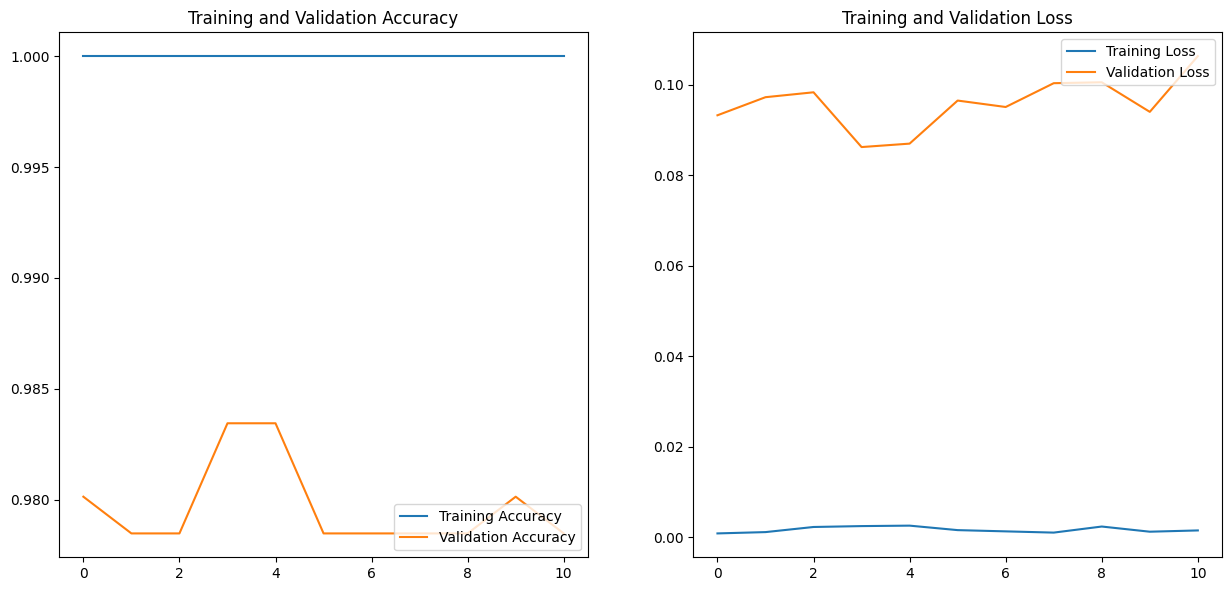

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## PREDICTIONS AND VISUALISATION OF MISCLASSIFIED IMAGES

In [ ]:
ADNET_model.load_weights(path)

In [ ]:
predictions = ADNET_model.predict(X_test)
actual_ylabel = y_test

#print("The prediction for this image is: ", predictions)
print("The actual label for this image is: ", actual_ylabel)

y_hat = np.argmax(predictions, axis = 1) # We take the highest probability
print('prediction label:', y_hat)

#Compare the predictions and labels and get the accuracy
accuracy = np.mean(np.equal(actual_ylabel, y_hat))
print(f"Accuracy: {accuracy:.2f}")

The actual label for this image is:  [0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0
 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0
 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1
 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1
 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0
 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0
 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0
 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1
 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0
 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1
 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1
 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 

misclassified indices: [203 219 264 271 492 556 589 595]
no of missclassification: 8


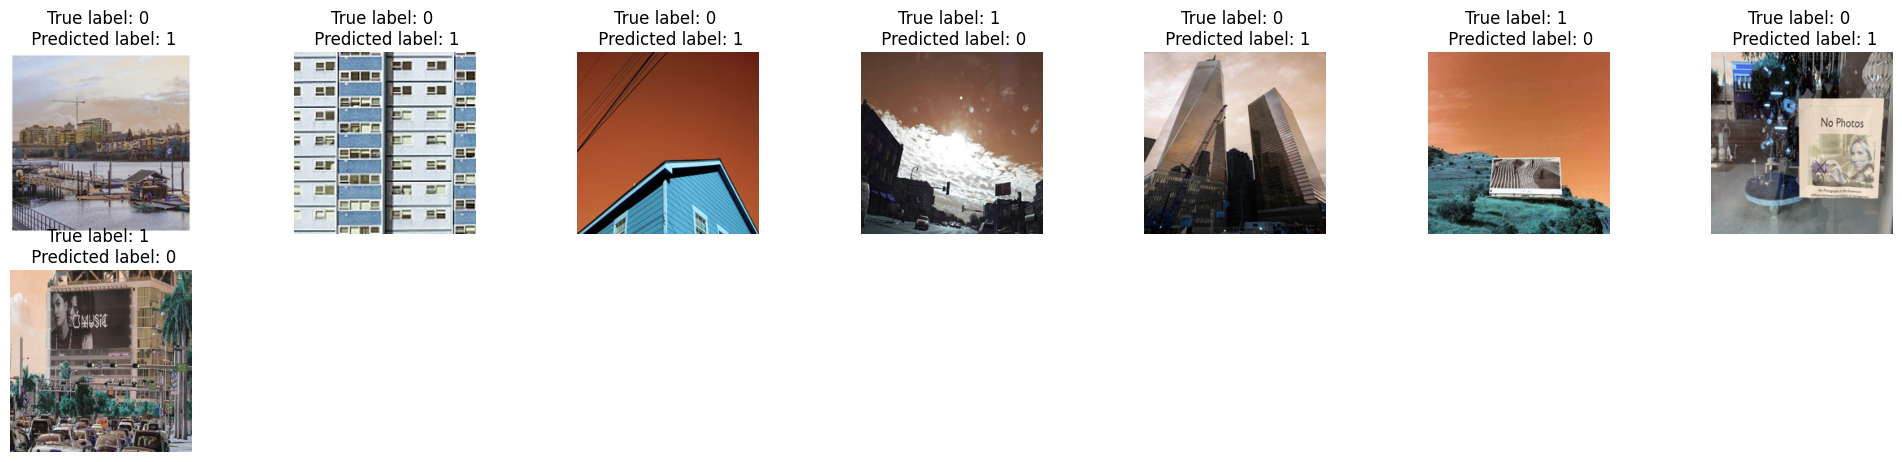

In [ ]:
# Compare y_hat to y_val
misclassified = []
label_comparison =  actual_ylabel == y_hat
misclassified = np.where(label_comparison == False)[0]  # Get the indices of misclassified images
print('misclassified indices:',misclassified)
print('no of missclassification:', len(misclassified))
plt.figure(figsize=(25, 25))
for i, index in enumerate(misclassified):
    ax =plt.subplot(9, 7, i+1)
    plt.imshow(X_test[index])
    plt.title("True label: {} \n Predicted label: {}".format(actual_ylabel[index], y_hat[index]))
    plt.axis('off')

Calculate the  evaluation metric: Recall, Precision, Accucracy

In [ ]:
pre = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()
acc = tf.keras.metrics.BinaryAccuracy()
rootmsqrerror = tf.keras.metrics.RootMeanSquaredError()
auc_roc = tf.keras.metrics.AUC()

In [ ]:
tf.math.confusion_matrix(
    y_test,
    y_hat,
    num_classes=2,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[280,   5],
       [  3, 316]])>

In [ ]:
pre.update_state(y_test, y_hat)
rec.update_state(y_test, y_hat)
acc.update_state(y_test, y_hat)
rootmsqrerror.update_state(y_test, y_hat)
auc_roc.update_state(y_test, y_hat)



print(f'Precision:{pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')
print(f'RMSE:{rootmsqrerror.result().numpy()}')
print(f'AUC:{auc_roc.result().numpy()}')

f1_score = 2 * (pre.result().numpy() * rec.result().numpy()) / (pre.result().numpy() + rec.result().numpy())

print(f'F1score:{f1_score}')

Precision:0.9844236969947815, Recall:0.9905956387519836, Accuracy:0.9867549538612366
RMSE:0.11508706957101822
AUC:0.9865258932113647
F1score:0.9875000475323527


Save the model

In [ ]:
#from tf.keras.models import load_model

path = f"/python_programming/FYP_2022/Models/model/"
ADNET_model.save(os.path.join(path, 'ALOS_VGG19ADNET_modelkfold.h5'))

new_model = tf.keras.models.load_model(os.path.join(path, 'ALOS_VGG19ADNET_modelkfold.h5'))

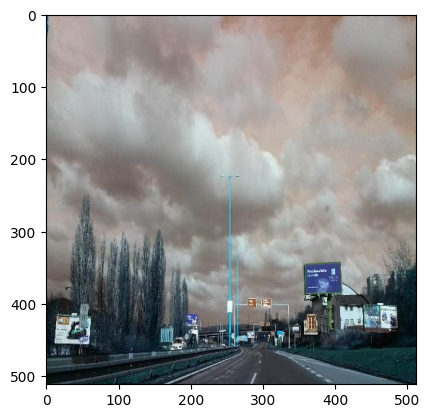

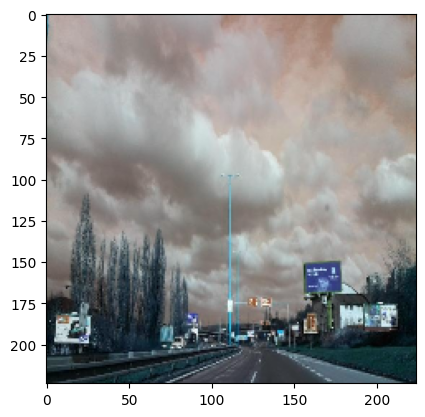

[[0.00630531 0.9936947 ]]
1
Predicted class belongs to billboard class


In [ ]:
newtest = cv2.imread('/python_programming/FYP_2022/billboard_dataset/output1/Billboard/scene_1223.jpg')
plt.imshow(newtest)
plt.show()

resize_newtest = cv2.resize(newtest, (224, 224))
plt.imshow(resize_newtest)
plt.show()
pred_newtest = np.expand_dims(resize_newtest/255, 0)
#print(pred_newtest)

y_pred_newtest = new_model.predict(pred_newtest)
print(y_pred_newtest)
y_pred_newtest = np.argmax(y_pred_newtest, axis = 1)
print(y_pred_newtest)

if y_pred_newtest > 0.5:
  print('Predicted class belongs to billboard class')

else:
  print('Predicted class belongs to no billboad class')